In [3]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [98]:
training_data = np.load('data/training.npy', allow_pickle=True) # shape: (frame, calibration)
test_data = np.load('data/test.npy', allow_pickle=True) # shape: (frame,)

In [118]:
# make sure to handle NaN values

im = Image.fromarray(training_data[5000][0])
im.show()

(1001.0, 3000.0, 0.0, 0.2)

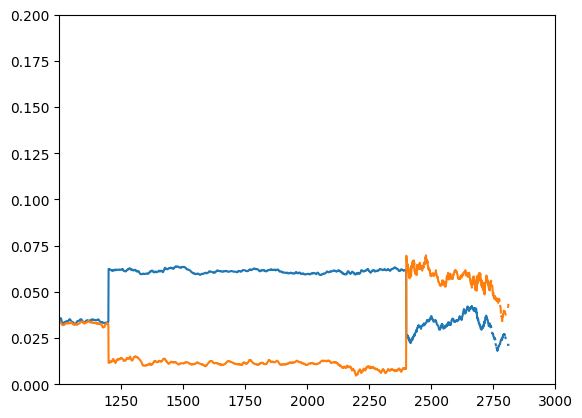

In [122]:
radians = training_data[:,1]
r1 = [r1 for r1, _ in radians]
r2 = [r2 for _, r2 in radians]
x = [i for i in range(len(radians))]

plt.plot(x, r1, label='r1')
plt.plot(x, r2, label='r2')
plt.axis([1001, 3000, 0, 0.2])